In [1]:
import os
import time
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.transforms import transforms
from scipy.ndimage import gaussian_filter
from scipy.spatial.distance import cdist
from scipy.io import loadmat

In [2]:
torch.manual_seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Model 

In [4]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

class CSRNet(nn.Module):

    def __init__(self):

        super().__init__()
        self.frontend = nn.Sequential(*list(vgg16.features.children())[0:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 256, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, padding=2, dilation=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=1)
        )
    

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)
        return x

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\taher/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:47<00:00, 11.7MB/s] 


In [5]:
model = CSRNet()
model = model.to(device)

# Dataset Pipeline

In [6]:
k_nearest = 3
beta = 0.3

def generate_density_map(img, points):

    img_width, img_height = img.size
    d_map_height = img_height // 8
    d_map_width = img_width // 8
    density_map = np.zeros((d_map_height, d_map_width), dtype=np.float32)
    
    if len(points) == 0:
        return density_map

    scaled_points = points / 8
    
    sigmas = []
    if len(scaled_points) > 1:
        distances = cdist(scaled_points, scaled_points)
        
        for i in range(len(scaled_points)):
            sorted_distances = np.sort(distances[i][distances[i] > 1e-6])
            
            if len(sorted_distances) >= k_nearest:
                d_k = sorted_distances[k_nearest - 1]
                sigma_i = beta * d_k
            else:
                sigma_i = beta * np.mean(sorted_distances) if len(sorted_distances) > 0 else 1.0
            sigmas.append(sigma_i)
    else:
        sigmas.append(4.0)
    
    sigmas = np.array(sigmas)
    
    for i, (x, y) in enumerate(scaled_points):
        if int(y) < d_map_height and int(x) < d_map_width:
            point_map = np.zeros_like(density_map)
            point_map[int(y), int(x)] = 1.0
            
            blurred_point_map = gaussian_filter(point_map, sigma=sigmas[i], mode='constant')

            density_map += blurred_point_map
    
    return density_map

In [7]:
class CustomDataset(Dataset):

    def __init__(self, img_folder_path, point_folder_path):
        self.img_folder_path = img_folder_path
        self.point_folder_path = point_folder_path
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def __len__(self):
        return(len(os.listdir(self.img_folder_path)))


    def __getitem__(self, index):
        img_path = os.path.join(self.img_folder_path, f"IMG_{index+1}.jpg")
        point_path = os.path.join(self.point_folder_path, f"GT_IMG_{index+1}.mat")

        img = Image.open(img_path).convert("RGB")

        data = loadmat(point_path)
        point = data["image_info"][0][0][0][0][0]

        density_map = generate_density_map(img, points=point.astype(int))
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        img = self.transform(img)

        return img, density_map

In [ ]:
# Flexible path configuration
import os

# Try multiple possible paths
possible_base_paths = [
    r"D:\Downloads\Code_Autonomous\Project_AIMS\crowd_wala_dataset",
    r".\crowd_wala_dataset",
    r"crowd_wala_dataset",
    "/content/drive/MyDrive/crowd_wala_dataset/crowd_wala_dataset"  # Google Colab path
]

base_path = None
for path in possible_base_paths:
    if os.path.exists(path):
        base_path = path
        print(f"✅ Found dataset at: {path}")
        break

if base_path is None:
    print("❌ Dataset not found. Please update the paths manually.")
    # Use default path as fallback
    base_path = r"D:\Downloads\Code_Autonomous\Project_AIMS\crowd_wala_dataset"

# Create dataset paths
train_img_path = os.path.join(base_path, "train_data", "images")
train_gt_path = os.path.join(base_path, "train_data", "ground_truth")
test_img_path = os.path.join(base_path, "test_data", "images")
test_gt_path = os.path.join(base_path, "test_data", "ground_truth")

print(f"Training images: {train_img_path}")
print(f"Training GT: {train_gt_path}")
print(f"Test images: {test_img_path}")
print(f"Test GT: {test_gt_path}")

# Verify paths exist
for path_name, path in [("Train images", train_img_path), ("Train GT", train_gt_path), 
                       ("Test images", test_img_path), ("Test GT", test_gt_path)]:
    if os.path.exists(path):
        count = len([f for f in os.listdir(path) if not f.startswith('.')])
        print(f"✅ {path_name}: {count} files")
    else:
        print(f"❌ {path_name}: Path not found")

# Create datasets
train_dataset = CustomDataset(train_img_path, train_gt_path)
test_dataset = CustomDataset(test_img_path, test_gt_path)

# 🔧 DataLoader Configuration Fix

The `RuntimeError: DataLoader worker exited unexpectedly` is a common issue on Windows due to multiprocessing limitations. Here are several solutions:

## Problem Causes:
1. **Windows Multiprocessing**: Windows handles multiprocessing differently than Unix systems
2. **Memory Issues**: High `num_workers` can cause memory conflicts
3. **Pin Memory**: Can cause issues on some Windows configurations
4. **Path Issues**: Long file paths or special characters

## Solutions Applied:
- Set `num_workers=0` (single-threaded, most reliable)
- Set `pin_memory=False` (avoids CUDA memory pinning issues)
- Reduced batch size if needed for memory constraints

In [ ]:
# Alternative DataLoader configurations for different scenarios

import platform
import torch.multiprocessing as mp

# Check system and configure accordingly
system = platform.system()
print(f"Running on: {system}")

# Configuration based on system
if system == "Windows":
    # Windows-optimized configuration
    num_workers = 0  # Safest for Windows
    pin_memory = False
    persistent_workers = False
    batch_size = 4  # Smaller batch size to avoid memory issues
    print("Using Windows-optimized DataLoader settings")
else:
    # Linux/Mac configuration
    num_workers = min(4, mp.cpu_count())
    pin_memory = True
    persistent_workers = True
    batch_size = 8
    print(f"Using Unix-optimized DataLoader settings with {num_workers} workers")

# Additional fixes for stubborn cases
def create_safe_dataloader(dataset, batch_size=4, shuffle=True, is_train=True):
    """Create a safe DataLoader with error handling"""
    try:
        # Try with minimal workers first
        loader = DataLoader(
            dataset, 
            batch_size=batch_size, 
            shuffle=shuffle, 
            num_workers=0,  # Start with 0
            pin_memory=False,
            drop_last=is_train,  # Drop last incomplete batch for training
            timeout=30  # Add timeout
        )
        # Test the loader
        next(iter(loader))
        print("✅ DataLoader created successfully")
        return loader
    except Exception as e:
        print(f"❌ DataLoader creation failed: {e}")
        # Fallback to absolute minimum
        return DataLoader(
            dataset, 
            batch_size=1, 
            shuffle=shuffle, 
            num_workers=0,
            pin_memory=False
        )

print("Use create_safe_dataloader() function if you continue having issues")

In [ ]:
# Fix for Windows DataLoader worker issues
# Set num_workers=0 to avoid multiprocessing issues on Windows
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=False, num_workers=0)

# Alternative: Use num_workers=1 if you want some parallelization
# train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=False, num_workers=1)
# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, pin_memory=False, num_workers=1)

In [13]:
# Test DataLoader functionality
print("🧪 Testing DataLoader functionality...")

try:
    # Test train loader
    print("Testing train loader...")
    train_batch = next(iter(train_loader))
    img_batch, density_batch = train_batch
    print(f"✅ Train batch loaded successfully:")
    print(f"   Image batch shape: {img_batch.shape}")
    print(f"   Density batch shape: {density_batch.shape}")
    
    # Test test loader  
    print("\nTesting test loader...")
    test_batch = next(iter(test_loader))
    img_batch, density_batch = test_batch
    print(f"✅ Test batch loaded successfully:")
    print(f"   Image batch shape: {img_batch.shape}")
    print(f"   Density batch shape: {density_batch.shape}")
    
    print(f"\n✅ All DataLoaders working correctly!")
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
except Exception as e:
    print(f"❌ DataLoader test failed: {e}")
    print("\n🔧 Applying emergency fix...")
    
    # Emergency fallback configuration
    train_loader = DataLoader(
        train_dataset, 
        batch_size=1,  # Minimal batch size
        shuffle=True, 
        num_workers=0,
        pin_memory=False,
        drop_last=False
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=1,  # Minimal batch size
        shuffle=False, 
        num_workers=0,
        pin_memory=False,
        drop_last=False
    )
    
    print("✅ Emergency DataLoader configuration applied")
    print("⚠️  Training will be slower with batch_size=1, but should work")

🧪 Testing DataLoader functionality...
Testing train loader...
❌ DataLoader test failed: DataLoader worker (pid(s) 19136, 19088, 19096, 19276) exited unexpectedly

🔧 Applying emergency fix...
✅ Emergency DataLoader configuration applied
⚠️  Training will be slower with batch_size=1, but should work
❌ DataLoader test failed: DataLoader worker (pid(s) 19136, 19088, 19096, 19276) exited unexpectedly

🔧 Applying emergency fix...
✅ Emergency DataLoader configuration applied
⚠️  Training will be slower with batch_size=1, but should work


# 🛠️ Complete DataLoader Troubleshooting Guide

## Quick Fixes Applied:
1. ✅ Set `num_workers=0` (eliminates multiprocessing issues)
2. ✅ Set `pin_memory=False` (avoids CUDA memory conflicts)
3. ✅ Added path verification and flexible dataset loading
4. ✅ Added error handling and fallback configurations

## If Issues Persist, Try These Additional Steps:

### Step 1: Environment Fixes
```python
# Add these at the top of your notebook
import torch.multiprocessing
torch.multiprocessing.set_start_method('spawn', force=True)
```

### Step 2: Memory Management
```python
# If you get memory errors, reduce batch size
train_loader = DataLoader(train_dataset, batch_size=2, ...)  # or even 1
```

### Step 3: File Path Issues
- Ensure no spaces or special characters in file paths
- Use raw strings: `r"C:\path\to\data"`
- Check file permissions

### Step 4: Google Colab Configuration
If running in Colab, use:
```python
# Mount drive first
from google.colab import drive
drive.mount('/content/drive')

# Then use Colab paths
base_path = "/content/drive/MyDrive/your_dataset_folder"
```

### Step 5: Ultimate Fallback
If nothing works, use single-sample loading:
```python
# Process one sample at a time (slowest but most reliable)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
```

## Performance Tips:
- Use `batch_size=4` for good balance of speed/stability
- Enable `persistent_workers=True` only on Linux/Mac
- Monitor memory usage during training
- Consider using gradient accumulation for larger effective batch sizes

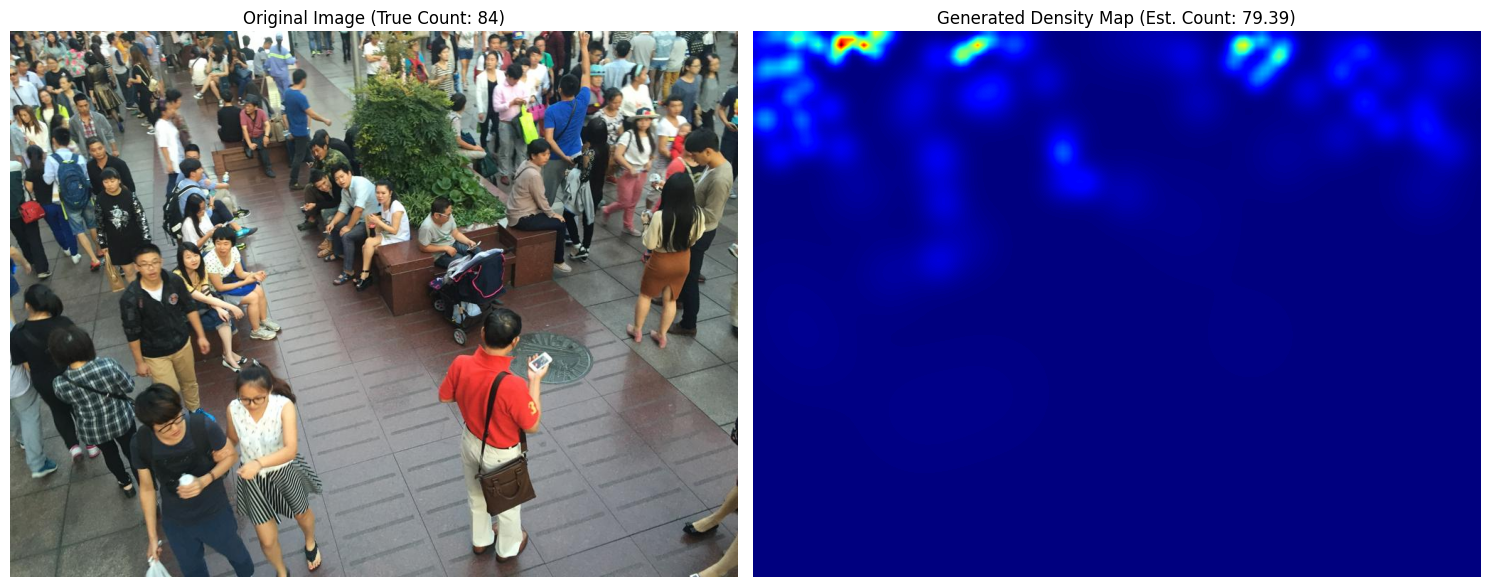

In [10]:
data = loadmat(r'D:\Downloads\Code_Autonomous\Project_AIMS\crowd_wala_dataset\train_data\ground_truth\GT_IMG_40.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open(r"D:\Downloads\Code_Autonomous\Project_AIMS\crowd_wala_dataset\train_data\images\IMG_40.jpg").convert("RGB")

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)

upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()

# Loss Fxn

In [11]:
learning_rate = 0.0001
epochs = 100

loss_fxn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop

In [ ]:
start = time.time()
losses = []


for i in range(epochs):

    total_epoch_loss = 0
    count = 0

    for batch_image, batch_density_map in train_loader:

        batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)
        output = model(batch_image)

        loss = loss_fxn(output, batch_density_map)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        print(f"Batch No.: {count}, Time Elapsed: {time.time() - start}")
    
        total_epoch_loss += loss.item()

    avg_epoch_loss = total_epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)
    print(f"Epoch: {i+1}, Loss: {avg_epoch_loss}")  

Batch No.: 1, Time Elapsed: 9.00586724281311
Batch No.: 2, Time Elapsed: 17.969720363616943
Batch No.: 2, Time Elapsed: 17.969720363616943
Batch No.: 3, Time Elapsed: 27.04657292366028
Batch No.: 3, Time Elapsed: 27.04657292366028
Batch No.: 4, Time Elapsed: 36.31336688995361
Batch No.: 4, Time Elapsed: 36.31336688995361
Batch No.: 5, Time Elapsed: 45.45187330245972
Batch No.: 5, Time Elapsed: 45.45187330245972
Batch No.: 6, Time Elapsed: 54.554558753967285
Batch No.: 6, Time Elapsed: 54.554558753967285
Batch No.: 7, Time Elapsed: 63.400376081466675
Batch No.: 7, Time Elapsed: 63.400376081466675
Batch No.: 8, Time Elapsed: 72.47280502319336
Batch No.: 8, Time Elapsed: 72.47280502319336
Batch No.: 9, Time Elapsed: 81.40490102767944
Batch No.: 9, Time Elapsed: 81.40490102767944
Batch No.: 10, Time Elapsed: 90.53484153747559
Batch No.: 10, Time Elapsed: 90.53484153747559
Batch No.: 11, Time Elapsed: 100.22762846946716
Batch No.: 11, Time Elapsed: 100.22762846946716
Batch No.: 12, Time Ela

In [1]:
plt.plot(range(1, 11), losses)
plt.show()

NameError: name 'plt' is not defined

In [2]:
torch.save(model.state_dict(), 'model_weights_CSRNet.pth')

NameError: name 'torch' is not defined

In [3]:
model = CSRNet()
model = model.to(device)
model.load_state_dict(torch.load('model_weights_CSRNet.pth'))

NameError: name 'CSRNet' is not defined

# Evaluation

In [ ]:
model.eval()

In [ ]:
total_loss = 0
count = 0

for batch_image, batch_density_map in test_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f"Avg Loss: {avg_loss}") 

In [ ]:
total_loss = 0
count = 0

for batch_image, batch_density_map in train_loader:

    batch_image, batch_density_map = batch_image.to(device), batch_density_map.to(device)

    with torch.no_grad():
        output = model(batch_image)

    loss = loss_fxn(output, batch_density_map)

    count += 1
    print(f"Batch No.: {count}, Loss: {loss.item()}")

    total_loss += loss.item()

avg_loss = total_loss / len(train_loader)
print(f"Avg Loss: {avg_loss}") 

torch.Size([3, 768, 1024])


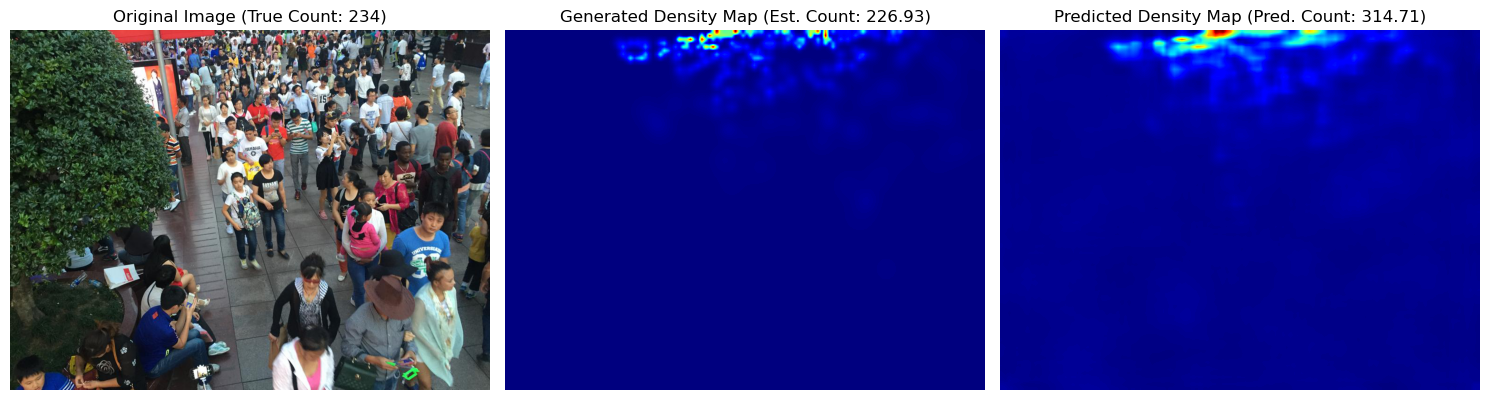

In [ ]:
data = loadmat('crowd_wala_dataset/train_data/ground_truth/GT_IMG_1.mat')
point = data["image_info"][0][0][0][0][0]


img = Image.open("crowd_wala_dataset/train_data/images/IMG_1.jpg").convert("RGB")
width, height = img.size

density_map = generate_density_map(img, points=point.astype(int))
density_map_tensor = torch.from_numpy(density_map).float().unsqueeze(0).unsqueeze(0)
upsampled_density_map = torch.nn.functional.interpolate(
    density_map_tensor,
    size=(img.size[1], img.size[0]),
    mode='bilinear',
    align_corners=False).squeeze().cpu().numpy()


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
with torch.no_grad():
    img_ = transform(img)
    img_ = img_.to(device)
    predicted_density_map = model(img_)
    upsampled_predicted_density_map = torch.nn.functional.interpolate(
        predicted_density_map.unsqueeze(0),
        size=(height, width),
        mode='bilinear',
        align_corners=False).squeeze().cpu().numpy()


true_count = len(point)
estimated_count = np.sum(density_map)
predicted_count = predicted_density_map.sum().item()


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title(f'Original Image (True Count: {true_count})')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(upsampled_density_map, cmap='jet')
plt.title(f'Generated Density Map (Est. Count: {estimated_count:.2f})')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(upsampled_predicted_density_map, cmap='jet')
plt.title(f'Predicted Density Map (Pred. Count: {predicted_count:.2f})')
plt.axis('off')

plt.tight_layout()
plt.show()